# EPL Machine Learning Walkthrough

## 02. Data Preparation & Feature Engineering
Welcome to the second part of this Machine Learning Walkthrough. This tutorial will focus on data preparation and feature creation, before we dive into modelling in the [next tutorial]('03. model_building').

Specifically, this tutorial will cover a few things:

1. Data wrangling specifically for sport
2. Feature creation - focussing on commonly used features in sports modelling, such as exponential moving averages
3. Using functions to modularise the data preparation process

### Data Wrangling
We will begin by utilising functions we have defined in our data_preparation_functions script to wrangle our data into a format that can be consumed by Machine Learning algorithms.

A typical issue faced by aspect of modelling sport is the issue of Machine Learning algorithms requiring all features for the teams playing to be on the same row of a table, whereas when we actual calculate these features, we usually require the teams to be on separate rows as it makes it a lot easier to calculate typical features, such as [expontentially weighted moving averages](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average). We will explore this issue and show how we deal with issues like these.

In [1]:
# Import libraries
from data_preparation_functions import *
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

We have created some functions which prepare the data for you. For thoroughly commented explanation of how the functions work, read through the data_preparation_functions.py script along side this walkthrough.

Essentially, each functions wrangles the data through a similar process. It first reads in the data from a csv file, then converts the columns to datatypes that we can work with, such as converting the Date column to a datetime data type. It then adds a Game ID column, so each game is easily identifiable and joined on. We then assign the DataFrame some other columns which may be useful, such as 'Year', 'Result' and 'homeWin'. Finally, we drop redundant column and return the DataFrame.

Let us now create six different DataFrames, which we will use to create features. Later, we will join these features back into one main feature DataFrame.

#### Create 6 distinct DataFrames

In [2]:
# This table includes all of our data in one big DataFrame
df = create_df('data/epl_data.csv')
df.head(3)

,AC,AF,AHh,AR,AS,AST,AY,Avg<2.5,Avg>2.5,AvgA,AvgAHA,AvgAHH,AvgD,AvgH,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,Date,Day,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,Max<2.5,Max>2.5,MaxA,MaxAHA,MaxAHH,MaxD,MaxH,Month,Referee,VCA,VCD,VCH,Year,season,gameId,homeWin,awayWin,result
0,6.0,14.0,0.00,1.0,11.0,5.0,1.0,2.02,1.71,2.74,2.04,1.82,3.16,2.40,Blackburn,2.75,3.20,2.5,2.90,3.30,2.20,2005-08-13,13,E0,1.0,3.0,H,2.0,11.0,0.0,13.0,5.0,1.0,0.0,A,0.0,West Ham,2.7,3.0,2.3,1.80,2.25,2.9,2.08,1.86,3.35,2.60,8,A Wiley,2.75,3.25,2.4,2005,0506,1,1,0,home
1,8.0,16.0,-0.25,0.0,13.0,6.0,2.0,2.01,1.70,3.05,1.84,2.01,3.16,2.20,Bolton,3.00,3.25,2.3,3.15,3.25,2.10,2005-08-13,13,E0,2.0,2.0,D,7.0,14.0,0.0,3.0,2.0,2.0,2.0,D,0.0,Aston Villa,3.1,3.0,2.1,1.87,2.20,3.4,1.92,2.10,3.30,2.40,8,M Riley,3.10,3.25,2.2,2005,0506,2,0,0,draw
2,6.0,14.0,0.75,0.0,12.0,5.0,1.0,1.93,1.79,1.69,1.86,2.00,3.36,4.69,Man United,1.72,3.40,5.0,1.75,3.35,4.35,2005-08-13,13,E0,2.0,0.0,A,8.0,15.0,0.0,10.0,5.0,1.0,0.0,A,3.0,Everton,1.8,3.1,3.8,1.87,2.10,1.8,1.93,2.05,3.70,5.65,8,G Poll,1.80,3.30,4.5,2005,0506,3,0,1,away


In [3]:
# This includes only the typical soccer stats, like home corners, home shots on target etc.
stats = create_stats_df('data/epl_data.csv')
stats.head(3)

,gameId,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1,West Ham,Blackburn,3.0,1.0,0.0,1.0,13.0,11.0,5.0,5.0,11.0,14.0,2.0,6.0,0.0,1.0,0.0,1.0
1,2,Aston Villa,Bolton,2.0,2.0,2.0,2.0,3.0,13.0,2.0,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0
2,3,Everton,Man United,0.0,2.0,0.0,1.0,10.0,12.0,5.0,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0


In [4]:
# This includes all of our betting related data, such as win/draw/lose odds, asian handicaps etc.
betting = create_betting_df('data/epl_data.csv')
betting.head(3)

,B365A,B365D,B365H,BWA,BWD,BWH,AHh,Avg<2.5,Avg>2.5,AvgA,AvgAHA,AvgAHH,AvgD,AvgH,Max<2.5,Max>2.5,MaxA,MaxAHA,MaxAHH,MaxD,MaxH,Day,Div,IWA,IWD,IWH,Month,VCA,VCD,VCH,Year,homeWin,awayWin,result,HomeTeam,AwayTeam,gameId
0,2.75,3.20,2.5,2.90,3.30,2.20,0.00,2.02,1.71,2.74,2.04,1.82,3.16,2.40,1.80,2.25,2.9,2.08,1.86,3.35,2.60,13,E0,2.7,3.0,2.3,8,2.75,3.25,2.4,2005,1,0,home,West Ham,Blackburn,1
1,3.00,3.25,2.3,3.15,3.25,2.10,-0.25,2.01,1.70,3.05,1.84,2.01,3.16,2.20,1.87,2.20,3.4,1.92,2.10,3.30,2.40,13,E0,3.1,3.0,2.1,8,3.10,3.25,2.2,2005,0,0,draw,Aston Villa,Bolton,2
2,1.72,3.40,5.0,1.75,3.35,4.35,0.75,1.93,1.79,1.69,1.86,2.00,3.36,4.69,1.87,2.10,1.8,1.93,2.05,3.70,5.65,13,E0,1.8,3.1,3.8,8,1.80,3.30,4.5,2005,0,1,away,Everton,Man United,3


In [5]:
# This includes all of the team information for each game.
team_info = create_team_info_df('data/epl_data.csv')
team_info.head(3)

,gameId,Date,season,HomeTeam,AwayTeam,FTR,HTR,Referee
0,1,2005-08-13,0506,West Ham,Blackburn,H,A,A Wiley
1,2,2005-08-13,0506,Aston Villa,Bolton,D,D,M Riley
2,3,2005-08-13,0506,Everton,Man United,A,A,G Poll


In [6]:
# Whilst the other DataFrames date back to 2005, this DataFrame has data from 2001 to 2005.
historic_games = create_historic_games_df('data/historic_games_pre2005.csv')
historic_games.head(3)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,gameId,season,homeWin
0,2001-08-18,Charlton,Everton,1,2,-1,20012002,0
1,2001-08-18,Derby,Blackburn,2,1,-1,20012002,1
2,2001-08-18,Leeds,Southampton,2,0,-1,20012002,1


In [7]:
# This is the historic_games DataFrame appended to the df DataFrame.
all_games = create_all_games_df('data/epl_data.csv', 'data/historic_games_pre2005.csv')
all_games.head(3)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,gameId,season,homeWin,awayWin,homeWinPc5,homeWinPc38,awayWinPc5,awayWinPc38,gameIdHistoric
0,2001-08-18,Charlton,Everton,1.0,2.0,-1,20012002,0,1,NaN,NaN,NaN,NaN,1
1,2001-08-18,Derby,Blackburn,2.0,1.0,-1,20012002,1,0,NaN,NaN,NaN,NaN,2
2,2001-08-18,Leeds,Southampton,2.0,0.0,-1,20012002,1,0,NaN,NaN,NaN,NaN,3


### Feature Creation
Now that we have all of our pre-prepared DataFrames, and we know that the data is clean, we can move onto feature creation. As is common practice with sports modelling, we are going to start by creating expontentially weighted moving averages (EMA) as features. To get a better understanding of how EMAs work, read [here](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average). 

In short, an EMA is like a simple moving average, except it weights recent instances more than older instances based on an alpha parameter. The documentation for the pandas (emw method)[https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html] we will be using states that we can specify alpha in a number of ways. We will specify it in terms of span, where $\alpha = 2 / (span+1), span ≥ 1 $.

Let's first define a function which calculates the exponential moving average for each column in the stats DataFrame. We will then apply this function with other functions we have created, such as create_betting_features_ema, which creates moving averages of betting data.

However, we must first change the structure of our data. Notice that currently each row has both the Home Team's data and the Away Team's data on a single row. This makes it difficult to calculate rolling averages, so we will restructure our DataFrames to ensure each row only contains single team's data. To do this, we will define a function, reate_multiline_df_stats.

In [8]:
# Define a function which restructures our DataFrame
def create_multiline_df_stats(old_stats_df):
    # Create a list of columns we want and their mappings to more interpretable names
    home_stats_cols = ['HomeTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY',
                       'HR', 'AR']
    
    away_stats_cols = ['AwayTeam', 'FTAG', 'FTHG', 'HTAG', 'HTHG', 'AS', 'HS', 'AST', 'HST', 'AF', 'HF', 'AC', 'HC', 'AY', 'HY',
                       'AR', 'HR']
    
    stats_cols_mapping = ['team', 'goalsFor', 'goalsAgainst', 'halfTimeGoalsFor', 'halfTimeGoalsAgainst', 'shotsFor',
                          'shotsAgainst', 'shotsOnTargetFor', 'shotsOnTargetAgainst', 'freesFor', 'freesAgainst', 
                          'cornersFor', 'cornersAgainst', 'yellowsFor', 'yellowsAgainst', 'redsFor', 'redsAgainst']
    
    # Create a dictionary of the old column names to new column names
    home_mapping = {old_col: new_col for old_col, new_col in zip(home_stats_cols, stats_cols_mapping)}
    away_mapping = {old_col: new_col for old_col, new_col in zip(away_stats_cols, stats_cols_mapping)}
    
    # Put each team onto an individual row
    multi_line_stats = (old_stats_df[['gameId'] + home_stats_cols] # Filter for only the home team columns
                    .rename(columns=home_mapping) # Rename the columns
                    .assign(homeGame=1) # Assign homeGame=1 so that we can use a general function later
                    .append((old_stats_df[['gameId'] + away_stats_cols]) # Append the away team columns
                            .rename(columns=away_mapping) # Rename the away team columns
                            .assign(homeGame=0), sort=True)
                    .sort_values(by='gameId') # Sort the values
                    .reset_index(drop=True))
    return multi_line_stats

In [9]:
# Define a function which creates an EMA DataFrame from the stats DataFrame
def create_stats_features_ema(stats, span):
    # Create a restructured DataFrames so that we can calculate EMA
    multi_line_stats = create_multiline_df_stats(stats)
    
    # Create a copy of the DataFrame
    ema_features = multi_line_stats[['gameId', 'team', 'homeGame']].copy()
    
    # Get the columns that we want to create EMA for
    feature_names = multi_line_stats.drop(columns=['gameId', 'team', 'homeGame']).columns
    
    # Loop over the features
    for feature_name in feature_names:
        feature_ema = (multi_line_stats.groupby('team')[feature_name] # Calculate the EMA
                                                  .transform(lambda row: row.ewm(span=span, min_periods=2)
                                                             .mean()
                                                             .shift(1))) # Shift the data down 1 so we don't leak data
        ema_features[feature_name] = feature_ema # Add the new feature to the DataFrame
    return ema_features

In [10]:
# Apply the function
stats_features = create_stats_features_ema(stats, span=5)
stats_features.tail()

,gameId,team,homeGame,cornersAgainst,cornersFor,freesAgainst,freesFor,goalsAgainst,goalsFor,halfTimeGoalsAgainst,halfTimeGoalsFor,redsAgainst,redsFor,shotsAgainst,shotsFor,shotsOnTargetAgainst,shotsOnTargetFor,yellowsAgainst,yellowsFor
10703,5352,Bournemouth,1,5.474658,4.541127,11.524695,9.975446,2.406581,1.369799,1.368981,1.002661,1.008633e-01,4.521922e-08,15.639945,10.852644,5.269541,4.303244,1.712254,1.912952
10704,5353,Arsenal,0,5.767398,7.872916,13.337359,9.658620,1.787448,1.603942,1.116424,0.547831,8.674677e-03,3.097659e-02,16.313139,16.696381,6.196574,5.833324,2.731536,2.284116
10705,5353,Watford,1,5.109495,6.024980,8.769407,11.524603,1.969531,0.734278,1.003919,0.577308,5.101890e-04,7.451864e-02,13.116599,14.524137,5.863971,3.223047,1.428955,2.047960
10706,5354,Aston Villa,1,9.128592,2.803439,14.509851,11.541738,1.433265,0.800416,0.469768,0.370109,1.479873e-11,3.686032e-01,17.647217,10.114410,4.260453,3.161858,1.869060,2.085488
10707,5354,West Ham,0,4.945140,6.002317,10.776904,11.254991,1.044732,1.980185,0.365731,0.760328,6.584362e-02,7.726068e-07,14.359579,14.180192,4.159062,6.866073,0.922662,1.563366


As we can see, we now have averages for each team. Let's create a quick table to see the top 10 teams' goalsFor average EMAs since 2005.

In [11]:
pd.DataFrame(stats_features.groupby('team')
                           .goalsFor
                           .mean()
                           .sort_values(ascending=False)[:10])

,goalsFor
team,
Man City,1.888023
Man United,1.881443
Arsenal,1.880073
Chelsea,1.866527
Liverpool,1.814601
Tottenham,1.664237
Leicester,1.410487
Blackpool,1.390936
Everton,1.384832


### Optimising Alpha
It looks like Man United and Chelsea have been two of the best teams since 2005, based on goalsFor. Now that we have our stats features, we may be tempted to move on. However, we have arbitrarily chosen a span of 5. How do we know that this is the best value? We don't. Let's try and optimise this value. 

To do this, we will use a simple Logistic Regression model to create probabilistic predictions based on the stats features we created before. We will iterate a range of span values, from say, 3 to 15, and choose the value which produces a model with the lowest log loss, based on cross validation.

To do this, we need to restructure our DataFrame back to how it was before.

In [11]:
def restructure_stats_features(stats_features):
    non_features = ['homeGame', 'team', 'gameId']

    stats_features_restructured = (stats_features.query('homeGame == 1')
                                    .rename(columns={col: 'f_' + col + 'Home' for col in stats_features.columns if col not in non_features})
                                    .rename(columns={'team': 'HomeTeam'})
                                    .pipe(pd.merge, (stats_features.query('homeGame == 0')
                                                        .rename(columns={'team': 'AwayTeam'})
                                                        .rename(columns={col: 'f_' + col + 'Away' for col in stats_features.columns 
                                                                         if col not in non_features})), on=['gameId'])
                                    .pipe(pd.merge, df[['gameId', 'result']], on='gameId')
                                    .dropna())
    return stats_features_restructured

restructure_stats_features(stats_features).head()

,gameId,HomeTeam,homeGame_x,f_cornersAgainstHome,f_cornersForHome,f_freesAgainstHome,f_freesForHome,f_goalsAgainstHome,f_goalsForHome,f_halfTimeGoalsAgainstHome,f_halfTimeGoalsForHome,f_redsAgainstHome,f_redsForHome,f_shotsAgainstHome,f_shotsForHome,f_shotsOnTargetAgainstHome,f_shotsOnTargetForHome,f_yellowsAgainstHome,f_yellowsForHome,AwayTeam,homeGame_y,f_cornersAgainstAway,f_cornersForAway,f_freesAgainstAway,f_freesForAway,f_goalsAgainstAway,f_goalsForAway,f_halfTimeGoalsAgainstAway,f_halfTimeGoalsForAway,f_redsAgainstAway,f_redsForAway,f_shotsAgainstAway,f_shotsForAway,f_shotsOnTargetAgainstAway,f_shotsOnTargetForAway,f_yellowsAgainstAway,f_yellowsForAway,result
20,21,Birmingham,1,4.8,7.8,12.0,9.4,1.2,0.6,0.6,0.6,0.0,0.0,11.4,8.2,6.4,2.8,1.0,2.6,Middlesbrough,0,3.0,5.6,14.0,12.8,1.2,0.0,0.0,0.0,0.0,0.4,17.2,8.8,7.6,2.6,3.0,1.4,away
21,22,Portsmouth,1,2.6,4.6,21.8,16.6,2.0,0.6,1.0,0.0,0.0,0.0,8.0,10.4,3.6,4.0,3.2,1.8,Aston Villa,0,9.8,7.0,14.2,18.2,1.4,0.8,0.8,0.8,0.0,0.0,16.0,3.0,9.6,2.6,2.0,0.6,draw
22,23,Sunderland,1,5.0,5.0,11.6,18.0,1.8,0.4,1.0,0.4,0.4,0.6,14.6,6.0,5.2,3.2,1.2,2.6,Man City,0,7.8,3.6,8.6,12.4,0.6,1.2,0.6,0.6,0.0,0.0,10.6,11.4,2.4,6.8,3.0,1.4,away
23,24,Arsenal,1,3.0,7.4,17.0,18.6,0.6,0.8,0.0,0.0,0.4,0.0,6.2,11.4,4.0,6.6,1.6,1.8,Fulham,0,7.2,3.0,20.8,13.2,1.2,0.6,0.6,0.0,0.0,0.0,12.4,10.8,7.0,5.2,2.0,1.6,home
24,25,Blackburn,1,1.4,7.2,12.8,21.2,1.8,1.6,0.0,1.0,0.0,0.4,10.0,14.0,4.4,7.4,1.2,1.6,Tottenham,0,6.4,3.8,11.2,18.8,0.0,2.0,0.0,0.4,0.0,0.0,11.6,15.2,4.6,7.2,0.6,2.6,draw


Now let's write a function that optimises our span based on log loss of the output of a Logistic Regression model.

In [12]:
def optimise_alpha(features):
    le = LabelEncoder()
    y = le.fit_transform(features.result) # Encode the result from away, draw, home win to 0, 1, 2
    X = features[[col for col in features.columns if col.startswith('f_')]] # Only get the features - these all start with f_
    lr = LogisticRegression()
    
    kfold = StratifiedKFold(n_splits=5)
    ave_cv_score = cross_val_score(lr, X, y, scoring='neg_log_loss', cv=kfold).mean()
    return ave_cv_score

In [13]:
best_score = np.float('inf')
best_span = 0
cv_scores = []

# Iterate over a range of spans
for span in range(1, 120, 3):
    stats_features = create_stats_features_ema(stats, span=span)
    restructured_stats_features = restructure_stats_features(stats_features)
    cv_score = optimise_alpha(restructured_stats_features)
    cv_scores.append(cv_score)
    
    if cv_score * -1 < best_score:
        best_score = cv_score * -1
        best_span = span

/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linea

/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linea

/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linea

/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linea

/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linea

/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linea

/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linea

/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linea

/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linea

/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linea

/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/groninge/anaconda3/lib/python3.7/site-packages/sklearn/linea

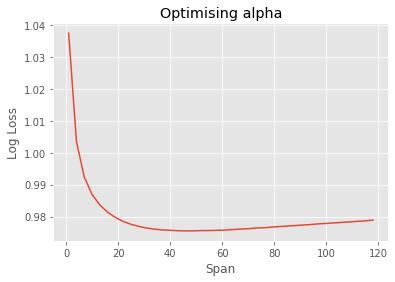

Our lowest log loss (0.975481) occurred at a span of 46


In [14]:
plt.style.use('ggplot')
plt.plot(list(range(1, 120, 3)), (pd.Series(cv_scores)*-1)) # Plot our results

plt.title("Optimising alpha")
plt.xlabel("Span")
plt.ylabel("Log Loss")
plt.show()

print("Our lowest log loss ({:2f}) occurred at a span of {}".format(best_score, best_span))

The above method is just an example of how you can optimise hyparameters. Obviously this example has many limitations, such as attempting to optimise each statistic with the same alpha. However, for the rest of these tutorial series we will use this span value.

Now let's create the rest of our features. For thorough explanations and the actual code behind some of the functions used, please refer to the data_preparation_functions.py script.

### Creating our Features DataFrame
We will utilise pre-made functions to create all of our features in just a few lines of code.

As part of this process we will create features which include margin weighted elo, an exponential average for asian handicap data, and odds as features.

Our Elo function is essentially the same as the one we created in the AFL tutorial; if you would like to know more about Elo models please read [this](https://www.betfair.com.au/hub/better-betting/betting-strategies/tennis/tennis-elo-modelling/) article.

Note that the cell below may take a few minutes to run.

In [16]:
# Create feature DataFrames
features_all_games = create_all_games_features(all_games)

/home/groninge/projects/predictive-models/epl/data_preparation_functions.py:419: RuntimeWarning: invalid value encountered in double_scalars
  .pipe(lambda df: (df.eloAgainst * df[goalsForOrAgainstCol]).sum() / df.eloAgainst.sum()))


The features_all_games df includes elo for each team, as well as their win percentage at home and away over the past 5 and 38 games. For more information on how it was calculated, read through the data_preparation_functions script.

In [17]:
features_all_games.head(3)

,Date,awayWin,awayWinPc38,awayWinPc5,eloAgainst,eloFor,gameId,gameIdHistoric,goalsAgainst,goalsFor,homeGame,homeWin,homeWinPc38,homeWinPc5,season,team,wtEloGoalsFor,wtEloGoalsAgainst
0,2001-08-18,1,NaN,NaN,1500.0,1500.0,-1,1,2.0,1.0,1,0,NaN,NaN,20012002,Charlton,NaN,NaN
1,2001-08-18,1,NaN,NaN,1500.0,1500.0,-1,1,1.0,2.0,0,0,NaN,NaN,20012002,Everton,NaN,NaN
2,2001-08-18,0,NaN,NaN,1500.0,1500.0,-1,2,1.0,2.0,1,1,NaN,NaN,20012002,Derby,NaN,NaN


The features_stats df includes all the expontential weighted averages for each stat in the stats df.

In [18]:
# Create feature stats df
features_stats = create_stats_features_ema(stats, span=best_span)
features_stats.tail(3)

,gameId,team,homeGame,cornersAgainst,cornersFor,freesAgainst,freesFor,goalsAgainst,goalsFor,halfTimeGoalsAgainst,halfTimeGoalsFor,redsAgainst,redsFor,shotsAgainst,shotsFor,shotsOnTargetAgainst,shotsOnTargetFor,yellowsAgainst,yellowsFor
10705,5353,Watford,1,5.122254,4.790287,10.207523,11.455984,1.733014,1.144619,0.763399,0.431855,0.054139,0.100366,12.965310,11.843185,5.097564,3.771512,1.274225,1.994106
10706,5354,Aston Villa,1,6.817793,4.125580,10.888395,10.880297,1.961547,0.767389,0.782749,0.320026,0.009736,0.146018,14.052246,9.914668,4.911764,3.117981,1.402528,1.841922
10707,5354,West Ham,0,5.507595,4.908340,10.659742,8.958764,1.481615,1.459544,0.582793,0.585607,0.039044,0.017573,14.380124,11.680444,5.110282,4.410384,1.392167,1.461667


The features_odds df includes a moving average of some of the odds data.

In [19]:
# Create feature_odds df
features_odds = create_betting_features_ema(betting, span=10)
features_odds.tail(3)

,gameId,team,avAsianHandicapOddsAgainst,avAsianHandicapOddsFor,avgreaterthan2.5,avlessthan2.5,sizeOfHandicap
10705,5353,Watford,1.974967,1.930044,2.047880,1.840185,0.111072
10706,5354,Aston Villa,1.928859,1.947553,1.936912,1.950918,0.712492
10707,5354,West Ham,1.968686,1.927294,1.947445,2.026561,0.344217


The features market values has market values and the % of total market for each position. These values are in millions.

In [20]:
# Create feature market values df
features_market_values = create_market_values_features(df) # This creates a df with one game per row
features_market_values.head(3)

,gameId,Year,HomeTeam,AwayTeam,defMktValH,attMktValH,gkMktValH,totalMktValH,midMktValH,defMktValA,attMktValA,gkMktValA,totalMktValA,midMktValA,attMktH%,attMktA%,midMktH%,midMktA%,defMktH%,defMktA%,gkMktH%,gkMktA%,totalMktH%,totalMktA%
0,1,2005,West Ham,Blackburn,16.90,18.50,6.40,46.40,4.60,27.25,13.00,3.25,70.70,27.20,2.252911,1.583126,0.588168,3.477861,2.486940,4.010007,4.524247,2.297469,1.913986,2.916354
1,2,2005,Aston Villa,Bolton,27.63,31.85,7.60,105.83,38.75,9.60,24.55,8.50,72.40,29.75,3.878659,2.989673,4.954673,3.803910,4.065926,1.412700,5.372543,6.008766,4.365456,2.986478
2,3,2005,Everton,Man United,44.35,31.38,8.55,109.78,25.50,82.63,114.60,9.25,288.48,82.00,3.821423,13.955867,3.260494,10.484727,6.526378,12.159517,6.044111,6.538951,4.528392,11.899714


In [21]:
all_games_cols = ['Date', 'gameId', 'team', 'season', 'homeGame', 'homeWinPc38', 'homeWinPc5', 'awayWinPc38', 'awayWinPc5', 'eloFor', 'eloAgainst', 'wtEloGoalsFor', 'wtEloGoalsAgainst']

# Join the features together
features_multi_line = (features_all_games[all_games_cols]
                                         .pipe(pd.merge, features_stats.drop(columns='homeGame'), on=['gameId', 'team'])
                                         .pipe(pd.merge, features_odds, on=['gameId', 'team']))

In [22]:
# Put each instance on an individual row
features_with_na = put_features_on_one_line(features_multi_line)

market_val_feature_names = ['attMktH%', 'attMktA%', 'midMktH%', 'midMktA%', 'defMktH%', 'defMktA%', 'gkMktH%', 'gkMktA%', 'totalMktH%', 'totalMktA%']

# Merge our team values dataframe to features and result from df
features_with_na = (features_with_na.pipe(pd.merge, (features_market_values[market_val_feature_names + ['gameId']])
                                                      .rename({col: 'f_' + col for col in market_val_feature_names}), on='gameId')
                            .pipe(pd.merge, df[['HomeTeam', 'AwayTeam', 'gameId', 'result', 'B365A', 'B365D', 'B365H']], on=['HomeTeam', 'AwayTeam', 'gameId']))

# Drop NAs from calculating the rolling averages - don't drop Win Pc 38 and Win Pc 5 columns
features = features_with_na.dropna(subset=features_with_na.drop(columns=[col for col in features_with_na.columns if 'WinPc' in col]).columns)

# Fill NAs for the Win Pc columns
features = features.fillna(features.mean())

In [23]:
features.head(3)

,Date,gameId,HomeTeam,season,homeGame,f_homeWinPc38Home,f_homeWinPc5Home,f_awayWinPc38Home,f_awayWinPc5Home,f_eloForHome,f_eloAgainstHome,f_wtEloGoalsForHome,f_wtEloGoalsAgainstHome,f_cornersAgainstHome,f_cornersForHome,f_freesAgainstHome,f_freesForHome,f_goalsAgainstHome,f_goalsForHome,f_halfTimeGoalsAgainstHome,f_halfTimeGoalsForHome,f_redsAgainstHome,f_redsForHome,f_shotsAgainstHome,f_shotsForHome,f_shotsOnTargetAgainstHome,f_shotsOnTargetForHome,f_yellowsAgainstHome,f_yellowsForHome,f_avAsianHandicapOddsAgainstHome,f_avAsianHandicapOddsForHome,f_avgreaterthan2.5Home,f_avlessthan2.5Home,f_sizeOfHandicapHome,AwayTeam,f_homeWinPc38Away,f_homeWinPc5Away,f_awayWinPc38Away,f_awayWinPc5Away,f_eloForAway,f_eloAgainstAway,f_wtEloGoalsForAway,f_wtEloGoalsAgainstAway,f_cornersAgainstAway,f_cornersForAway,f_freesAgainstAway,f_freesForAway,f_goalsAgainstAway,f_goalsForAway,f_halfTimeGoalsAgainstAway,f_halfTimeGoalsForAway,f_redsAgainstAway,f_redsForAway,f_shotsAgainstAway,f_shotsForAway,f_shotsOnTargetAgainstAway,f_shotsOnTargetForAway,f_yellowsAgainstAway,f_yellowsForAway,f_avAsianHandicapOddsAgainstAway,f_avAsianHandicapOddsForAway,f_avgreaterthan2.5Away,f_avlessthan2.5Away,f_sizeOfHandicapAway,attMktH%,attMktA%,midMktH%,midMktA%,defMktH%,defMktA%,gkMktH%,gkMktA%,totalMktH%,totalMktA%,result,B365A,B365D,B365H
20,2005-08-23,21,Birmingham,0506,1,0.394737,0.4,0.263158,0.2,1478.687038,1492.866048,1.061763,1.260223,4.978261,7.532609,12.000000,9.934783,1.021739,0.51087,0.51087,0.51087,0.00000,0.00000,11.934783,8.021739,6.489130,2.978261,1.000000,2.510870,1.9090,1.9455,1.6735,2.0510,-0.1375,Middlesbrough,0.394737,0.4,0.263158,0.2,1492.866048,1478.687038,1.12994,1.279873,2.554348,5.51087,13.554348,13.423913,1.021739,0.000000,0.000000,0.000000,0.0,0.48913,17.021739,8.086957,7.510870,2.510870,3.0,1.48913,1.9395,1.9095,1.7155,2.0035,0.3875,5.132983,5.260851,3.341048,4.289788,3.502318,4.168935,2.332815,3.216457,3.934396,4.522205,away,2.75,3.2,2.50
21,2005-08-23,22,Portsmouth,0506,1,0.447368,0.4,0.263158,0.4,1405.968416,1489.229314,1.147101,1.503051,2.510870,4.956522,21.978261,16.065217,2.000000,0.51087,1.00000,0.00000,0.00000,0.00000,8.445652,10.489130,3.956522,4.445652,3.021739,1.532609,1.8965,1.9690,1.7005,2.0040,0.2500,Aston Villa,0.447368,0.4,0.263158,0.4,1489.229314,1405.968416,1.17516,1.263229,9.532609,7.00000,14.467391,17.576087,1.489130,0.978261,0.978261,0.978261,0.0,0.00000,15.554348,3.000000,9.065217,2.510870,2.0,0.51087,1.8565,1.9770,1.8485,1.8505,0.7125,3.738614,3.878659,4.494368,4.954673,2.884262,4.065926,3.746642,5.372543,3.743410,4.365456,draw,2.75,3.2,2.50
22,2005-08-23,23,Sunderland,0506,1,0.236842,0.0,0.236842,0.4,1277.888970,1552.291880,0.650176,1.543716,5.000000,5.000000,12.402174,17.554348,1.978261,0.48913,1.00000,0.48913,0.48913,0.51087,14.510870,6.891304,5.021739,3.913043,1.021739,2.510870,1.8520,1.9915,1.8500,1.8535,0.7125,Man City,0.236842,0.0,0.236842,0.4,1552.291880,1277.888970,1.28875,1.287367,7.532609,3.51087,8.956522,12.489130,0.510870,1.021739,0.510870,0.510870,0.0,0.00000,10.956522,11.934783,2.489130,6.978261,3.0,1.48913,1.8150,2.0395,1.7095,2.0060,-0.2000,0.706318,3.750792,1.476812,1.070209,2.634096,4.455890,0.777605,4.913050,1.499427,3.151477,away,2.50,3.2,2.75


We now have a features DataFrame ready, with all the feature columns beginning with the "f_". In the next tutorial, we will walk through the modelling process to try and find the best type of model to use.